In [ ]:
# CELLIER Roxane
# 21205907

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng
import scipy.integrate as integrate
import scipy.stats as stats

import seaborn as sns
sns.set_theme()

rng = default_rng()

# Génération de variables aléatoires discrètes

Le but de cet exercice est de mettre en pratique la méthode du rejet dans un cadre discret pour simuler des variables aléatoires de Poisson à partir de variables géométriques.

**Q1.** Vérifier analytiquement que si $U$ est une variable uniforme sur $[0,1]$, alors $X=\lfloor -\log_2 U\rfloor$ est une variable géométrique (sur $\mathbb{N}$) de paramètre $\frac{1}{2}$. Autrement dit, pour tout $k\in\mathbb{N}$, $\mathbb{P}[X=k]=2^{-(k+1)}$.

_Remarque._ Le logarithme en base 2 est obtenu par `np.log2`. Par défaut, les variables géométriques dans `scipy` sont à valeurs dans $\mathbb{N}^*$. On peut utiliser `geom = stats.geom(0.5,loc=-1)` pour pouvoir utiliser la densité discrète `geom.pmf` ou bien plus simplement utiliser directement la formule explicite rappelée au dessus.

$\mathbb{P}(X = k)    = P(\lfloor -log_2 U \rfloor = k) \newline
            = \mathbb{P}( k <= -log_2 U < k+1) \newline
            = \mathbb{P}( -k >= log_2 U > -(k+1)) \newline
            = \mathbb{P}( 2^{-k} >= U > 2^{-(k+1)}) \newline
            $

**Q2.** Utiliser cette propriété pour simuler $N=10000$ variables géométriques dans un vecteur `x` sur $\mathbb{N}$ à partir d'un échantillon de taille $N$ d'uniformes.

In [70]:
N = 10_000

sample_u = rng.random(N)
x = np.floor(-np.log2(sample_u))

**Q3.** Représenter l'histogramme de l'échantillon `x` et comparer avec la distribution théorique.

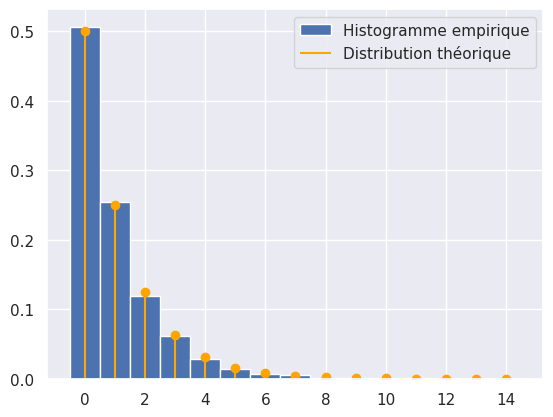

In [76]:
geom = stats.geom(0.5, loc=-1)

plt.hist(x, density=True, bins=np.arange(-0.5, 15.5, 1), label="Histogramme empirique")
plt.scatter(np.arange(0,15), geom.pmf(np.arange(0,15)), color='orange')
plt.vlines(np.arange(0,15), 0, geom.pmf(np.arange(0,15)), color='orange', label="Distribution théorique")
plt.legend()
plt.show()

On pose $\lambda=1$ et $c = e^{\lambda/2}$. Soit $X$ une variable géométrique sur $\mathbb{N}$ de paramètre $\frac{1}{2}$ et $Y$ une variable de Poisson de paramètre $\lambda$.

**Q4.** Montrer à l'aide d'une ligne de Python que pour tout $0\leq k\leq 100$, $\mathbb{P}[Y=k] \leq c \mathbb{P}[X=k]$. _On admet que par croissance comparée, cette relation est vraie aussi pour $k>100$_.

In [77]:
lmbda = 1
c = np.exp(lmbda/2)
K = np.arange(0,101)
poiss = stats.poisson(lmbda)

print( np.all(poiss.pmf(K) <= c* geom.pmf(K)) )

True


**Q5.** Reproduire les graphes suivants, montrant à gauche la mise en œuvre de la méthode du rejet pour simuler un échantillon de variables de Poisson à partir de `x`.

![rejet Poisson](data/rejet.png)

[6. 5. 1. ... 1. 4. 1.]


/tmp/ipykernel_3854/2054325260.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


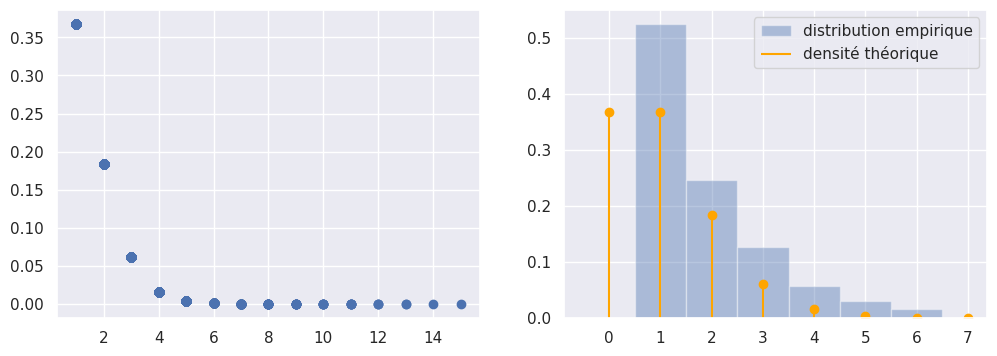

In [96]:
accepted = c*x >= poiss.pmf(x)
not_accepted = c*x < poiss.pmf(x)

support = np.linspace(0,15,16)
fig, axs = plt.subplots(1,2, figsize=(12,4))

axs[0].scatter(x[accepted], poiss.pmf(x[accepted]))

axs[1].hist(x[accepted], bins=np.arange(-0.5, 7.5, 1), density=True, alpha=0.4, label='distribution empirique')
axs[1].vlines(np.arange(0,8), 0, poiss.pmf(np.arange(0,8)), color='orange', label="densité théorique")
axs[1].scatter(np.arange(0,8), poiss.pmf(np.arange(0,8)), color='orange')
axs[1].legend()

fig.show()

**Q6.** Calculer la fraction de points acceptés et comparer à $c$. Conclure.

In [84]:
print("Rapport des pts acceptés : ", np.sum(accepted)/( np.sum(accepted)+np.sum(not_accepted) ))
print("valeur de c : ", c)

Rapport des pts acceptés :  0.4933
valeur de c :  1.6487212707001282


# Processus de Poisson inhomogène

Nous avions considéré dans le TP2 le processus de Poisson homogène, défini comme la fonction de comptage associé à un processus ponctuel $(T_n)_{n\geq 1}$ où les variables $T_n$ vérifiaient que:
$$
T_{n+1}-T_n = S_n,
$$
avec $(S_n)$ une suite de variables iid exponentielles de paramètre $\lambda$.

Nous généralisons dans cet exercice la notion de processus de Poisson lorsque la densité n'est pas constante au cours du temps, mais est donnée par une fonction $\lambda:[0,+\infty[ \to ]0, +\infty[$ strictement positive, appelée _fonction d'intensité_. On considère maintenant des instants de sauts $(T_n)_{n \ge 1}$ (avec toujours $T_0 = 0$) donnés par la dynamique $T_{n} = T_{n-1} + S_n$ où pour tout $n \ge 1$, $S_n$ est une variable aléatoire sur $]0,+\infty[$ définie conditionnellement à $T_{n-1}$ par 
$$
    \begin{aligned}
    \forall s > 0, \forall t_{n-1} > 0, \quad
    \mathbf{P} \bigl[S_n > s \; \bigl\vert \; T_{n-1} = t_{n-1} \bigr] &= \exp \bigl(-\int_0^s \lambda(u + t_{n-1}) d u \bigr) \\
      &= \exp \bigl(- (\Lambda(t_{n-1} + s) - \Lambda(t_{n-1})) \bigr) \\
    \end{aligned}
$$
avec $\Lambda(t) = \int_0^t \lambda(u) d u$ l'intensité intégrée.
<!--Dans la suite on note $\Lambda^{-1}$ la réciproque de $\Lambda$.-->

### Simulation par la méthode des sauts fictifs (thinning)
On suppose maintenant que la fonction d'intensité est bornée 
$$
    \exists \bar \lambda > 0, \quad \forall t \ge 0, \quad \lambda(t) \le \bar \lambda.
$$
Soit $(\bar T_n)_{n \ge 1}$ les instants de sauts d'un processus de poisson $(\bar N_t)_{t \ge 0}$ d'intensité $\bar \lambda$. On peut simuler les instants de sauts $(T_n)_{n \ge 1}$ en supprimant certains sauts de $(\bar T_n)_{n \ge 1}$. Plus précisément, on considère $(U_n)_{n \ge 1}$ une suite _i.i.d._ de loi uniforme sur $[0,1]$ et on construit la suite d'indices $(\tau_n)_{n \ge 1}$ par la récurrence
$$
     \forall n \ge 0, \quad \tau_{n+1} = 
     \min \Bigl\{ k > \tau_n, U_k \le \frac{\lambda(\bar T_k)}{\bar \lambda} \Bigr\}
     \qquad \tau_0 = 0
$$
Alors les sauts de $(\bar N_t)_{t \ge 0}$ d'indices $(\tau_n)_{n \ge 1}$ sont les sauts d'un processus de Poisson inhomogène de fonction d'intensité $\lambda$. On peut alors construire $(T_n)_{n \ge 1}$ en posant $T_n = \bar T_{\tau_n}$.

_Remarque : c'est une variante de la méthode du rejet pour le processus de Poisson._

Pour illustrer cette méthode, on va prendre représenter une réalisation du processus de Poisson inhomogène sur l'intervalle $[0,A]$ avec $A=10$, pour la densité définie par $\lambda(t)=2+\sin(\pi \sqrt{t})$.

**Q1.** Déterminer une valeur de $\bar\lambda$.

In [100]:
from scipy import optimize
import math

A = 10
opti = optimize.minimize_scalar(lambda x: -(2+np.sin( math.pi*np.sqrt(x))), bounds=(0,A), method="bounded")
print("lmbda opti : ", -opti.fun)
lambda_tilde = -opti.fun

lmbda opti :  2.9999999999999702


**Q2.** Générer les instants de saut $(\bar{T}_k)$ d'un processus de Poisson d'intensité $\bar\lambda$. On rappelle que le nombre $\bar{N}(A)$ de sauts dans l'intervalle $[0,A]$ est une loi de Poisson de paramètre $\bar\lambda A$, et qu'étant donné $\bar{N}(A)$, la loi de $(\bar{T}_1,\bar{T}_2,\ldots,\bar{T}_{\bar{N}(A)})$ est la mếme que $\bar{N}(A)$ variables uniformes indépendantes sur $[0,A]$ triées dans l'ordre croissant.

On stockera $\bar{N}(A)$ dans une variable `nbar` et la liste des instants de $\bar{T}$ inférieurs à $A$ dans un vecteur `tbar`.

In [125]:
nbar = rng.poisson(lambda_tilde*A)

tbar = np.sort(rng.uniform(0,A,nbar))

**Q3.** Générer un vecteur `u` de même longueur que `tbar` de variables indépendantes et uniformes sur $[0,\bar\lambda]$.

In [127]:
u = rng.uniform(0, lambda_tilde, size=len(tbar))
print(u)

[1.21384595 1.62629865 0.2387529  0.99058034 2.24577915 0.70341825
 1.0698366  2.36419745 1.7460883  2.75391626 2.55955268 1.31663294
 1.9467281  1.96746764 0.50212512 0.79782857 0.32312513 2.34250348
 2.69186181 2.72535467 0.43631026 2.00959685 1.22464431 0.46612773
 0.86810914 0.59644009 2.51762191 1.542845   1.13274529 1.42635487
 2.22824654 1.14367381 0.07788166 1.17273676 2.47750496 2.256303
 0.72575166 0.97468985 0.66518397 1.32619568 2.40119107]


**Q4.** Sur un même graphique, représenter la courbe de la fonction $\lambda$ en rouge, et le nuage de points dont les abscisses sont dans `tbar` et les ordonnées dans `u`. On dessinera les points en dessous de $\lambda$ en bleu, et ceux au dessus en orangé. On devrait obtenir quelque-chose ressemblant à la figure ci-dessous :

![Méthode du thinning](data/thinning.png)

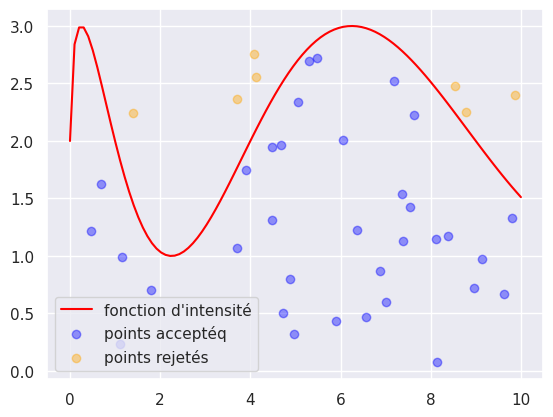

In [133]:
t = np.linspace(0,10, 100)

accepted = u <= 2+np.sin(math.pi*np.sqrt(tbar))
not_accepted = u > 2+np.sin(math.pi*np.sqrt(tbar))

plt.plot(t, 2+np.sin(math.pi*np.sqrt(t)), color='red', label="fonction d'intensité")
plt.scatter(tbar[accepted], u[accepted], color='blue', alpha=0.4, label="points acceptéq")
plt.scatter(tbar[not_accepted], u[not_accepted], color='orange', alpha=0.4, label="points rejetés")

plt.legend()
plt.show()

# Monte-Carlo


On se propose de calculer une valeur approchée de
$$\ln(2)=\int_0^1 \frac{du}{1+u}$$
par la méthode de Monte-Carlo.

**Q0.** écrire une fonction `monte_carlo` qui prend en paramètre un échantillon $(X_i)_{0\leq i\leq n-1}$ et qui renvoie l'estimateur de l'espérance empirique, la variance empirique, et les bornes inférieure et supérieure de l'intervalle de confiance asymptotique à 95% donné par le théorème central limite.

In [101]:
def monte_carlo(sample):
    moy = np.mean(sample)
    var = np.var(sample, ddof=1)
    n = len(sample)

    quantile = stats.norm.ppf(1-(1-0.95)/2)
    borne_inf = moy - quantile * np.sqrt(var/n)
    borne_sup = moy + quantile * np.sqrt(var/n)

    return moy, var, borne_inf, borne_sup

**Q1.** Afficher dans un dataFrame `pandas` le résultat de la méthode de Monte-Carlo pour différentes valeurs de $N$ : $10^i$ pour i=3,4,5,6.

In [122]:
import pandas as pd

Ns = np.power(10, [3,4,5,6])

def func(x):
    return 1/(1+x)

res = [monte_carlo(func(rng.random(n))) for n in Ns]

index_y = ["mean", "var", "low", "high"]
df = pd.DataFrame(res, index=Ns, columns=index_y)
df

,mean,var,low,high
1000,0.686699,0.019614,0.678019,0.695379
10000,0.691593,0.019323,0.688869,0.694318
100000,0.693241,0.019528,0.692375,0.694107
1000000,0.693241,0.019559,0.692967,0.693516


**Q2.** Proposer un schéma de simulation utilisant des variables antithétiques (et deux fois moins de variables uniformes indépendantes), et afficher dans un nouveau dataFrame les résultats de cette nouvelle méthode de Monte-Carlo. Montrer que la variance est divisée par un facteur 30 environ.

In [124]:
res_antit = []

for n in Ns:
    sample = rng.random(n)
    res_antit.append( monte_carlo((func(sample)+func(-sample)) /2) )

index_y = ["mean", "var", "low", "high"]
df_antit = pd.DataFrame(res_antit, index=Ns, columns=index_y)

df_antit["var"]/df["var"]

1000       2.717465e+04
10000      3.418197e+05
100000     2.285961e+07
1000000    2.532663e+07
Name: var, dtype: float64

# Algorithme de Métropolis et recuit simulé

On considère la fonction $f$ définie par la formule (compliquée) suivante : pour $x\in[0,2\pi]$,
$$ f(x) = -(1+\frac{\sin(x-\frac{\pi}{6})^2}{5})e^{-\sin(2x-\frac{\pi}{6})^2}.$$

Cette fonction est $\pi$-périodique. Elle est donc considérée comme une fonction sur le cercle $\mathbb{R}/\pi\mathbb{Z}$.

In [106]:
def f(x):
    return -(1+0.2*np.sin(x-np.pi/6)**2)*np.exp(-np.sin(2*x-np.pi/6)**2)

Le but de ce sujet est d'explorer les minima locaux de $f$ à l'aide d'une chaine de Markov.

**Q1.** Construire `x0` une discrétisation de l'intervalle $[0,\pi]$ avec $N=1000$ points. Utiliser le pour dessiner le graphe de $f$. On appelle `delta` ($\delta$) la quantité $\pi/N$ correspondant à la distance entre deux points successifs de `x0`.

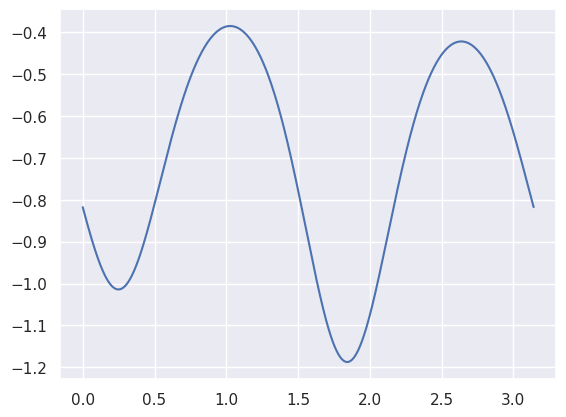

In [108]:
N = 1_000
x0 = np.linspace(0, math.pi, N)
delta = math.pi/N

plt.plot(x0, f(x0))
plt.show()

On considère la chaîne de Markov $P$ qui réalise la marche aléatoire simple sur les points du cercle discret `x0`. Si on est en un point `x`, avec probabilité $\frac{1}{2}$, on saute en `x+delta` (modulo $\pi$), et sinon, on saute en `x-delta` (modulo $\pi$).

**Q2.** implémenter une fonction `phi_P` qui prend en argument un vecteur `x` de `numpy` contenant des valeurs de `x0`, et qui renvoie l'évolution après une étape (de façon indépendante) de ces valeurs dans un nouveau vecteur. _Remarque : l'opération modulo s'obtient avec le symbole `%`_. Tester en regardant les 10 premières itérations de la chaîne en partant de l'unique point 0.

In [ ]:
def phi_P(x):
    #
    rand = rng.binom

On définit pour $T>0$ la fonction $\mu_T\colon:x\mapsto e^{-f(x)/T}$. On cherche à définir une nouvelle chaîne de Markov $Q_T$ sur les points de `x_0` dont la mesure invariante serait proportionnelle à $\mu_T$ sur `x0`.

**Q3.** Écrire une fonction python `mu` qui prend un vecteur `x` de valeurs de `x0` et une valeur `T` (par défaut égale à 1), et qui renvoie $\mu_T$ évaluée sur tous les coefficients de `x`. 

**Q4.** Écrire une fonction `phi_Q` qui représente la modification de la chaîne $P$ par l'algorithme de Métropolis-Hastings, pour une mesure invariante proportionnelle à $\mu_T$. 

**Q5.** Faire évoluer 100 000 fois (des copies de `x0`) pour la chaîne $Q_T$ pour les valeurs $T=1$ et $T=0.1$. (on appellera les résultats `x1` et `x2` respectivement). Calculer les constantes $c_1$ et $c_2$ correspondant aux intégrales de $mu_T$ pour $T=1$ et $T=0.1$ respectivement.
_On pourra utiliser `integrate.quad` qui prend trois paramètres : la fonction à intégrer et les deux bornes d'intégration (c'est une fonction de `scipy` importée dans la première cellule_.

**Q6.** Reproduire le graphe suivant montrant pour $T=1$ et $T=0.1$ la répartition empirique des vecteurs `x1` et `x2` comparée avec les distributions invariantes proportionnelles à $\mu_T$.

![Métropolis](data/metropolis.png)

On voit que plus $T$ est petit, plus la distribution empirique de la chaine de Markov $Q_T$ est concentrée sur les minimaux locaux de $H$. On veut maintenant utiliser le recuit simulé pour obtenir une valeur approchée de ces minimums.

**Q6.** Écrire une fonction `recuit_simulé` qui prend un vecteur de valeurs possibles `x` extraites de `x0`, une fonction de température `temp` et un nombre d'itérations `nb_iter` égal par défaut à 3000, et qui renvoit le résultat de l'évolution par les matrices $Q_{\text{temp}(n)}$ des valeurs de `x`.

In [89]:
def temp1(n):
    return 0.1/np.log(n+2)

def temp2(n):
    return 0.4/np.log(n+2)

def temp3(n):
    return 0.02/np.log(n+2)

**Q7.** Fixer un vecteur `x` avec 100 valeurs tirées au hasard parmi `x0`. Pour $i=1,2,3$, notons `xf`$i$ le vecteur obtenu par le recuit simulé avec la fonction de température `temp`$i$ et le nombre d'itérations par défaut. Représenter sur le même graphique : le graphe de $f$, et les nuages de points `xf`$i$ (avec les ordonnées correspondantes par `f`, décalées de $0.1*i$). Pour quelle fonction de température la distribution des résultats est-elle la plus reserrée autour des minimums ? Pour chaque $i$, calculer la proportion de points autour de chaque minimum local.